使用 GPU: 1


/root/miniconda3/lib/python3.12/site-packages/transformers/tokenization_utils_base.py:2102: FutureWarning: Calling BertTokenizer.from_pretrained() with the path to a single file or url is deprecated and won't be possible anymore in v5. Use a model identifier or the path to a directory instead.
  warnings.warn(
Some weights of BertForSequenceClassification were not initialized from the model checkpoint at autodl-tmp/bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


==================== Epoch 1/10 ====================
Epoch 1 Train loss: 1.7826, Train accuracy: 0.1916
Epoch 1 Validation loss: 1.7626, Validation accuracy: 0.1931
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_1.pt
Checkpoint saved at autodl-tmp/checkpoints1/best_model.pt
New best model saved at autodl-tmp/checkpoints1/best_model.pt with accuracy 0.1931
==================== Epoch 2/10 ====================
Epoch 2 Train loss: 1.7845, Train accuracy: 0.1877
Epoch 2 Validation loss: 1.7723, Validation accuracy: 0.2048
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_2.pt
Checkpoint saved at autodl-tmp/checkpoints1/best_model.pt
New best model saved at autodl-tmp/checkpoints1/best_model.pt with accuracy 0.2048
==================== Epoch 3/10 ====================
Epoch 3 Train loss: 1.7837, Train accuracy: 0.1854
Epoch 3 Validation loss: 1.7730, Validation accuracy: 0.1589
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_3.pt
==================== Epoc

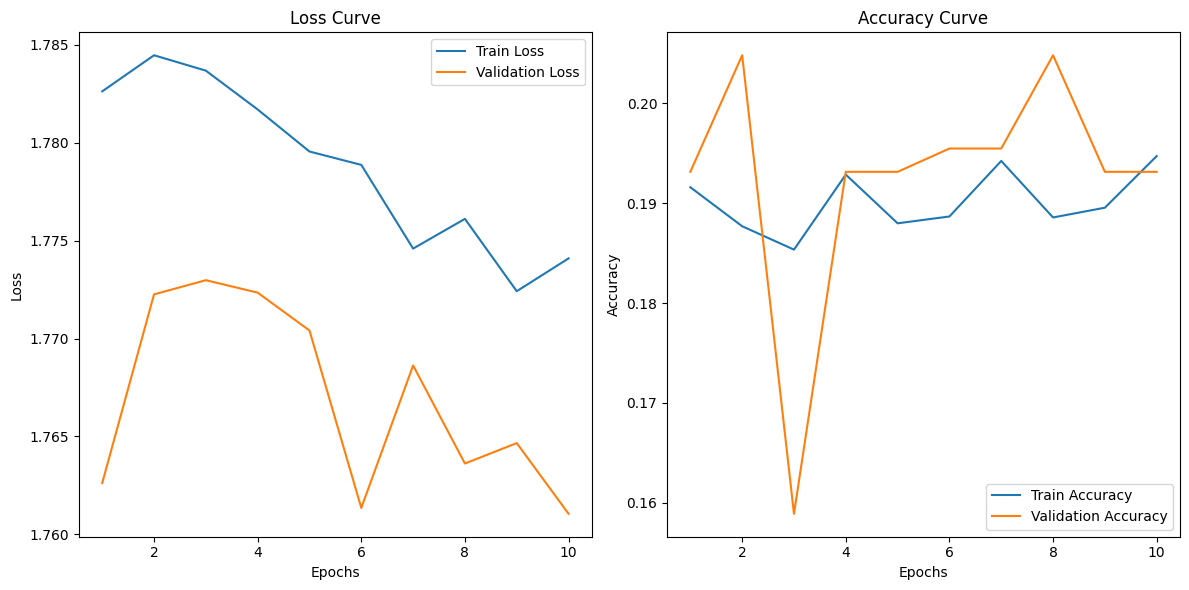

In [6]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt

# 查找空闲的 GPU
if torch.cuda.is_available():
    free_gpus = []
    for i in range(torch.cuda.device_count()):
        if torch.cuda.memory_allocated(i) == 0:
            free_gpus.append(i)
    if free_gpus:
        device = torch.device(f'cuda:{free_gpus[0]}')  # 使用空闲的第一个 GPU
        print(f'使用 GPU: {free_gpus[0]}')
    else:
        device = torch.device('cuda')  # 如果没有空闲 GPU，使用默认的 GPU
        print('没有空闲 GPU, 使用默认的 GPU')
else:
    device = torch.device('cpu')
    print('使用 CPU')

# 1. 加载数据集
train_data = pd.read_csv('train.tsv', sep='\t', header=None)
valid_data = pd.read_csv('valid.tsv', sep='\t', header=None)
test_data = pd.read_csv('test.tsv', sep='\t', header=None)

# 使用第三列作为文本，第二列作为标签
train_texts = train_data.iloc[:, 2].values
train_labels = train_data.iloc[:, 1].values

valid_texts = valid_data.iloc[:, 2].values
valid_labels = valid_data.iloc[:, 1].values

test_texts = test_data.iloc[:, 2].values
test_labels = test_data.iloc[:, 1].values

# 标签编码，将文本标签转换为数字
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# 2. 数据预处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('autodl-tmp/bert/tokenizer.json')

# 数据集准备
MAX_LEN = 128
BATCH_SIZE = 16

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
valid_dataset = TextDataset(valid_texts, valid_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 3. 定义模型、优化器和学习率调度器
model = BertForSequenceClassification.from_pretrained('autodl-tmp/bert', num_labels=len(set(train_labels)))
model = model.to(device)

# 优化器和调度器
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-2, correct_bias=False)
total_steps = len(train_loader) * 10
num_warmup_steps = int(total_steps * 0.1)  # 10%的步数用于warmup
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# 损失函数
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# 创建一个用于保存模型的目录
output_dir = "autodl-tmp/checkpoints1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存每个epoch的训练与验证损失、准确率
train_losses, val_losses = [], []
train_accs, val_accs = [], []



# 训练函数
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, epoch, gradient_accumulation_steps=2):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    optimizer.zero_grad()

    for step, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # 梯度累积
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        _, preds = torch.max(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 验证函数
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 训练并保存 checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

# 4. 训练和验证
EPOCHS = 10
best_val_acc = 0.0
for epoch in range(EPOCHS):
    print(f'{"="*20} Epoch {epoch + 1}/{EPOCHS} {"="*20}')
    
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, epoch)
    print(f'Epoch {epoch + 1} Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    
    val_loss, val_acc = eval_model(model, valid_loader, loss_fn, device)
    print(f'Epoch {epoch + 1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # 每个epoch保存一个checkpoint
    checkpoint_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch + 1}.pt")
    save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, checkpoint_path)
    
    # 保存验证准确率最高的模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(output_dir, "best_model.pt")
        save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, best_model_path)
        print(f"New best model saved at {best_model_path} with accuracy {best_val_acc:.4f}")

# 5. 测试模型
print(f'{"="*20} Testing {"="*20}')
test_loss, test_acc = eval_model(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

# 6. 绘制训练曲线
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


使用 GPU: 0


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at autodl-tmp/bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


==================== Epoch 1/10 ====================
Epoch 1 Train loss: 1.9196, Train accuracy: 0.1618
Epoch 1 Validation loss: 1.8467, Validation accuracy: 0.1869
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_1.pt
Checkpoint saved at autodl-tmp/checkpoints1/best_model.pt
New best model saved at autodl-tmp/checkpoints1/best_model.pt with accuracy 0.1869
==================== Epoch 2/10 ====================
Epoch 2 Train loss: 1.7910, Train accuracy: 0.1991
Epoch 2 Validation loss: 1.7581, Validation accuracy: 0.2009
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_2.pt
Checkpoint saved at autodl-tmp/checkpoints1/best_model.pt
New best model saved at autodl-tmp/checkpoints1/best_model.pt with accuracy 0.2009
==================== Epoch 3/10 ====================
Epoch 3 Train loss: 1.7483, Train accuracy: 0.2254
Epoch 3 Validation loss: 1.7424, Validation accuracy: 0.2290
Checkpoint saved at autodl-tmp/checkpoints1/checkpoint_epoch_3.pt
Checkpoint saved at autod

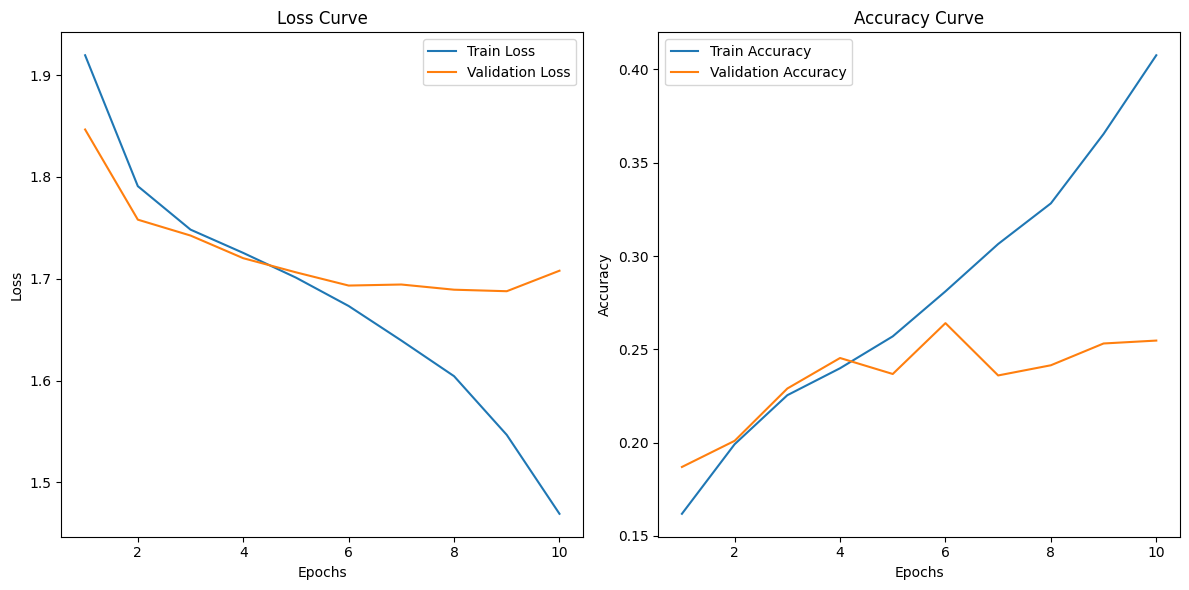

In [9]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt

# 查找空闲的 GPU
if torch.cuda.is_available():
    free_gpus = []
    for i in range(torch.cuda.device_count()):
        if torch.cuda.memory_allocated(i) == 0:
            free_gpus.append(i)
    if free_gpus:
        device = torch.device(f'cuda:{free_gpus[0]}')  # 使用空闲的第一个 GPU
        print(f'使用 GPU: {free_gpus[0]}')
    else:
        device = torch.device('cuda')  # 如果没有空闲 GPU，使用默认的 GPU
        print('没有空闲 GPU, 使用默认的 GPU')
else:
    device = torch.device('cpu')
    print('使用 CPU')

# 1. 加载数据集
train_data = pd.read_csv('train.tsv', sep='\t', header=None)
valid_data = pd.read_csv('valid.tsv', sep='\t', header=None)
test_data = pd.read_csv('test.tsv', sep='\t', header=None)

# 使用第三列作为文本，第二列作为标签
train_texts = train_data.iloc[:, 2].values
train_labels = train_data.iloc[:, 1].values

valid_texts = valid_data.iloc[:, 2].values
valid_labels = valid_data.iloc[:, 1].values

test_texts = test_data.iloc[:, 2].values
test_labels = test_data.iloc[:, 1].values

# 标签编码，将文本标签转换为数字
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# 2. 数据预处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('autodl-tmp/bert')

# 数据集准备
MAX_LEN = 128
BATCH_SIZE = 64  # 调整批量大小

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
valid_dataset = TextDataset(valid_texts, valid_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 3. 定义模型、优化器和学习率调度器
model = BertForSequenceClassification.from_pretrained('autodl-tmp/bert', num_labels=len(set(train_labels)))
model = model.to(device)

# 冻结前8层
for param in model.bert.encoder.layer[:8].parameters():
    param.requires_grad = False

# 优化器和调度器
optimizer = AdamW(model.parameters(), lr=1e-5, weight_decay=5e-2)  # 调整学习率和权重衰减
total_steps = len(train_loader) * 20  # 增加训练轮次
num_warmup_steps = int(total_steps * 0.2)  # 增加warmup步数
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# 损失函数
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# 训练、验证和绘制图表的部分保持不变
# 创建一个用于保存模型的目录
output_dir = "autodl-tmp/checkpoints1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存每个epoch的训练与验证损失、准确率
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# 训练函数
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, epoch, gradient_accumulation_steps=2):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    optimizer.zero_grad()

    for step, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # 梯度累积
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        _, preds = torch.max(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 验证函数
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 训练并保存 checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

# 4. 训练和验证
EPOCHS = 10
best_val_acc = 0.0
for epoch in range(EPOCHS):
    print(f'{"="*20} Epoch {epoch + 1}/{EPOCHS} {"="*20}')
    
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, epoch)
    print(f'Epoch {epoch + 1} Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    
    val_loss, val_acc = eval_model(model, valid_loader, loss_fn, device)
    print(f'Epoch {epoch + 1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # 每个epoch保存一个checkpoint
    checkpoint_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch + 1}.pt")
    save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, checkpoint_path)
    
    # 保存验证准确率最高的模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(output_dir, "best_model.pt")
        save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, best_model_path)
        print(f"New best model saved at {best_model_path} with accuracy {best_val_acc:.4f}")

# 5. 测试模型
print(f'{"="*20} Testing {"="*20}')
test_loss, test_acc = eval_model(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

# 6. 绘制训练曲线
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


In [2]:
import torch
if torch.cuda.is_available():
    free_gpus = []
    for i in range(torch.cuda.device_count()):
        if torch.cuda.memory_allocated(i) == 0:
            free_gpus.append(i)
    if free_gpus:
        device = torch.device(f'cuda:{free_gpus[0]}')  # 使用空闲的第一个 GPU
        print(f'使用 GPU: {free_gpus[0]}')
    else:
        device = torch.device('cuda')  # 如果没有空闲 GPU，使用默认的 GPU
        print('没有空闲 GPU, 使用默认的 GPU')
else:
    device = torch.device('cpu')
    print('使用 CPU')

使用 GPU: 0


In [1]:
import pandas as pd
import torch
from torch.utils.data import DataLoader, Dataset
from transformers import BertTokenizer, BertForSequenceClassification, AdamW
from transformers import get_linear_schedule_with_warmup
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score
import numpy as np
import os
import matplotlib.pyplot as plt

# 强制使用 GPU 1
if torch.cuda.is_available():
    device = torch.device('cuda:1')  # 强制使用 GPU 1
    print('使用 GPU: 1')
else:
    device = torch.device('cpu')
    print('使用 CPU')

# 1. 加载数据集
train_data = pd.read_csv('train.tsv', sep='\t', header=None)
valid_data = pd.read_csv('valid.tsv', sep='\t', header=None)
test_data = pd.read_csv('test.tsv', sep='\t', header=None)

# 使用第三列作为文本，第二列作为标签
train_texts = train_data.iloc[:, 2].values
train_labels = train_data.iloc[:, 1].values

valid_texts = valid_data.iloc[:, 2].values
valid_labels = valid_data.iloc[:, 1].values

test_texts = test_data.iloc[:, 2].values
test_labels = test_data.iloc[:, 1].values

# 标签编码，将文本标签转换为数字
label_encoder = LabelEncoder()
train_labels = label_encoder.fit_transform(train_labels)
valid_labels = label_encoder.transform(valid_labels)
test_labels = label_encoder.transform(test_labels)

# 2. 数据预处理
class TextDataset(Dataset):
    def __init__(self, texts, labels, tokenizer, max_len):
        self.texts = texts
        self.labels = labels
        self.tokenizer = tokenizer
        self.max_len = max_len

    def __len__(self):
        return len(self.texts)

    def __getitem__(self, idx):
        text = str(self.texts[idx])
        label = self.labels[idx]
        encoding = self.tokenizer.encode_plus(
            text,
            add_special_tokens=True,
            max_length=self.max_len,
            return_token_type_ids=False,
            padding='max_length',
            truncation=True,
            return_attention_mask=True,
            return_tensors='pt'
        )
        return {
            'text': text,
            'input_ids': encoding['input_ids'].flatten(),
            'attention_mask': encoding['attention_mask'].flatten(),
            'labels': torch.tensor(label, dtype=torch.long)
        }

# 加载BERT tokenizer
tokenizer = BertTokenizer.from_pretrained('autodl-tmp/bert')

# 数据集准备
MAX_LEN = 128
BATCH_SIZE = 128  # 增加批量大小

train_dataset = TextDataset(train_texts, train_labels, tokenizer, MAX_LEN)
valid_dataset = TextDataset(valid_texts, valid_labels, tokenizer, MAX_LEN)
test_dataset = TextDataset(test_texts, test_labels, tokenizer, MAX_LEN)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=BATCH_SIZE)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE)

# 3. 定义模型、优化器和学习率调度器
model = BertForSequenceClassification.from_pretrained('autodl-tmp/bert', num_labels=len(set(train_labels)))
model = model.to(device)

# 冻结前8层
for param in model.bert.encoder.layer[:8].parameters():
    param.requires_grad = False

# 优化器和调度器
optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=1e-1)  # 调整学习率和权重衰减
total_steps = len(train_loader) * 20  # 增加训练轮次
num_warmup_steps = int(total_steps * 0.3)  # 增加warmup步数至30%
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps=num_warmup_steps, num_training_steps=total_steps)

# 损失函数
loss_fn = torch.nn.CrossEntropyLoss().to(device)

# 训练、验证和绘制图表的部分保持不变
# 创建一个用于保存模型的目录
output_dir = "autodl-tmp/checkpoints1"
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# 保存每个epoch的训练与验证损失、准确率
train_losses, val_losses = [], []
train_accs, val_accs = [], []

# 训练函数
def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler, epoch, gradient_accumulation_steps=4):
    model = model.train()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    optimizer.zero_grad()

    for step, batch in enumerate(data_loader):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)

        # 梯度累积
        loss = loss / gradient_accumulation_steps
        loss.backward()

        if (step + 1) % gradient_accumulation_steps == 0:
            optimizer.step()
            scheduler.step()
            optimizer.zero_grad()

        total_loss += loss.item() * gradient_accumulation_steps
        _, preds = torch.max(logits, dim=1)
        total_correct += (preds == labels).sum().item()
        total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 验证函数
def eval_model(model, data_loader, loss_fn, device):
    model = model.eval()
    total_loss = 0
    total_correct = 0
    total_examples = 0

    with torch.no_grad():
        for step, batch in enumerate(data_loader):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['labels'].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)

            total_loss += loss.item()
            _, preds = torch.max(logits, dim=1)
            total_correct += (preds == labels).sum().item()
            total_examples += labels.size(0)

    avg_loss = total_loss / len(data_loader)
    avg_acc = total_correct / total_examples
    return avg_loss, avg_acc

# 训练并保存 checkpoint
def save_checkpoint(model, optimizer, scheduler, epoch, loss, path):
    checkpoint = {
        'epoch': epoch,
        'model_state_dict': model.state_dict(),
        'optimizer_state_dict': optimizer.state_dict(),
        'scheduler_state_dict': scheduler.state_dict(),
        'loss': loss
    }
    torch.save(checkpoint, path)
    print(f"Checkpoint saved at {path}")

# 4. 训练和验证
EPOCHS = 10
best_val_acc = 0.0
for epoch in range(EPOCHS):
    print(f'{"="*20} Epoch {epoch + 1}/{EPOCHS} {"="*20}')
    
    train_loss, train_acc = train_epoch(model, train_loader, loss_fn, optimizer, device, scheduler, epoch)
    print(f'Epoch {epoch + 1} Train loss: {train_loss:.4f}, Train accuracy: {train_acc:.4f}')
    
    val_loss, val_acc = eval_model(model, valid_loader, loss_fn, device)
    print(f'Epoch {epoch + 1} Validation loss: {val_loss:.4f}, Validation accuracy: {val_acc:.4f}')
    
    train_losses.append(train_loss)
    val_losses.append(val_loss)
    train_accs.append(train_acc)
    val_accs.append(val_acc)

    # 每个epoch保存一个checkpoint
    checkpoint_path = os.path.join(output_dir, f"checkpoint_epoch_{epoch + 1}.pt")
    save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, checkpoint_path)
    
    # 保存验证准确率最高的模型
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_path = os.path.join(output_dir, "best_model.pt")
        save_checkpoint(model, optimizer, scheduler, epoch + 1, val_loss, best_model_path)
        print(f"New best model saved at {best_model_path} with accuracy {best_val_acc:.4f}")

# 5. 测试模型
print(f'{"="*20} Testing {"="*20}')
test_loss, test_acc = eval_model(model, test_loader, loss_fn, device)
print(f'Test loss: {test_loss:.4f}, Test accuracy: {test_acc:.4f}')

# 6. 绘制训练曲线
epochs_range = range(1, EPOCHS + 1)

plt.figure(figsize=(12, 6))

# 损失曲线
plt.subplot(1, 2, 1)
plt.plot(epochs_range, train_losses, label="Train Loss")
plt.plot(epochs_range, val_losses, label="Validation Loss")
plt.title("Loss Curve")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()

# 准确率曲线
plt.subplot(1, 2, 2)
plt.plot(epochs_range, train_accs, label="Train Accuracy")
plt.plot(epochs_range, val_accs, label="Validation Accuracy")
plt.title("Accuracy Curve")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()


使用 GPU: 1


Some weights of BertForSequenceClassification were not initialized from the model checkpoint at autodl-tmp/bert and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.
/root/miniconda3/lib/python3.12/site-packages/transformers/optimization.py:591: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


==================== Epoch 1/10 ====================


OutOfMemoryError: CUDA out of memory. Tried to allocate 64.00 MiB. GPU  has a total capacity of 23.64 GiB of which 23.75 MiB is free. Process 950993 has 23.61 GiB memory in use. Of the allocated memory 23.19 GiB is allocated by PyTorch, and 26.35 MiB is reserved by PyTorch but unallocated. If reserved but unallocated memory is large try setting PYTORCH_CUDA_ALLOC_CONF=expandable_segments:True to avoid fragmentation.  See documentation for Memory Management  (https://pytorch.org/docs/stable/notes/cuda.html#environment-variables)